In [1]:
from pepnets.PeptideNetwork import PeptideNetwork
import random
import pandas as pd
import numpy as np


random.seed(42)
np.random.seed(42)

sus_scrofa = pd.read_csv("../data/sus_scrofa.gz", sep="\t")
sus_scrofa["Entry Name"] = sus_scrofa["Entry Name"].apply(lambda x: x.split("_")[0])
datamatrix = pd.read_csv("../data/data.csv")
is_multi = datamatrix["Protein"].value_counts() > 3 # we cannot build communities with less than 3 peptides
datamatrix = datamatrix[datamatrix["Protein"].isin(is_multi[is_multi].index)]
pnet = PeptideNetwork(
    datamatrix=datamatrix,
    protein_database=sus_scrofa,
)

Reading peptides...


In [2]:
pnet.create_network(distance_cutoff=4)

{'ACTS': <networkx.classes.graph.Graph at 0x10759a160>,
 'ATIF1': <networkx.classes.graph.Graph at 0x10751f9a0>,
 'MYL6': <networkx.classes.graph.Graph at 0x10751f670>,
 'TBA1A': <networkx.classes.graph.Graph at 0x10759a370>,
 'SFTPA': <networkx.classes.graph.Graph at 0x10759a9a0>,
 'ITIH4': <networkx.classes.graph.Graph at 0x10759ae50>,
 'ITIH1': <networkx.classes.graph.Graph at 0x10752d220>,
 'APOA1': <networkx.classes.graph.Graph at 0x10752d910>,
 'TRFE': <networkx.classes.graph.Graph at 0x10759a340>,
 'PLMN': <networkx.classes.graph.Graph at 0x10759a760>,
 'HBB': <networkx.classes.graph.Graph at 0x10759a700>,
 'PF12': <networkx.classes.graph.Graph at 0x10759a1f0>,
 'PGS2': <networkx.classes.graph.Graph at 0x10759aa90>,
 'KCRM': <networkx.classes.graph.Graph at 0x10759a790>,
 'OSTP': <networkx.classes.graph.Graph at 0x10752d310>,
 'HS71A': <networkx.classes.graph.Graph at 0x10752d190>,
 'PROC': <networkx.classes.graph.Graph at 0x10752d850>,
 'PR39': <networkx.classes.graph.Graph at 

In [3]:
pnet.get_clusters(resolution=0.8)

['ACTS_0', 'ACTS_1', 'ACTS_2', 'ACTS_3', 'ACTS_4', 'ACTS_5', 'ACTS_6', 'ACTS_7', 'ACTS_8', 'ACTS_9', 'ACTS_10', 'ACTS_11', 'ACTS_12', 'ACTS_13', 'ACTS_14', 'ACTS_15', 'ACTS_16', 'ACTS_17', 'ACTS_18', 'ACTS_19', 'ACTS_20', 'ACTS_21', 'ACTS_22', 'ACTS_23', 'ACTS_24', 'ACTS_25', 'ACTS_26', 'ACTS_27', 'ACTS_28', 'ATIF1_0', 'ATIF1_1', 'ATIF1_2', 'MYL6_0', 'MYL6_1', 'MYL6_2', 'MYL6_3', 'MYL6_4', 'MYL6_5', 'MYL6_6', 'MYL6_7', 'MYL6_8', 'MYL6_9', 'MYL6_10', 'MYL6_11', 'MYL6_12', 'TBA1A_0', 'TBA1A_1', 'TBA1A_2', 'TBA1A_3', 'TBA1A_4', 'TBA1A_5', 'TBA1A_6', 'TBA1A_7', 'TBA1A_8', 'TBA1A_9', 'TBA1A_10', 'TBA1A_11', 'TBA1A_12', 'TBA1A_13', 'SFTPA_0', 'SFTPA_1', 'SFTPA_2', 'ITIH4_0', 'ITIH4_1', 'ITIH4_2', 'ITIH4_3', 'ITIH4_4', 'ITIH4_5', 'ITIH4_6', 'ITIH4_7', 'ITIH4_8', 'ITIH4_9', 'ITIH4_10', 'ITIH4_11', 'ITIH4_12', 'ITIH4_13', 'ITIH4_14', 'ITIH4_15', 'ITIH4_16', 'ITIH4_17', 'ITIH4_18', 'ITIH4_19', 'ITIH4_20', 'ITIH4_21', 'ITIH4_22', 'ITIH4_23', 'ITIH4_24', 'ITIH4_25', 'ITIH1_0', 'ITIH1_1', 'ITIH1_2'

<Figure size 640x480 with 0 Axes>

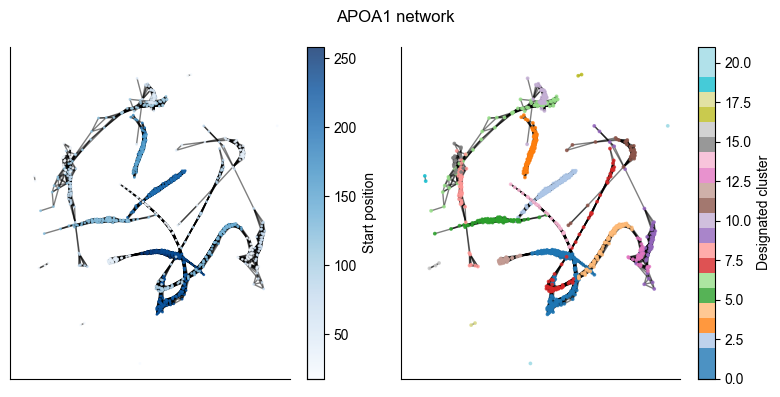

In [4]:
pnet.plot_protein("APOA1", save_str="../plots/APOA1.png")

In [5]:
pnet.clusters

['ACTS_0', 'ACTS_1', 'ACTS_2', 'ACTS_3', 'ACTS_4', 'ACTS_5', 'ACTS_6', 'ACTS_7', 'ACTS_8', 'ACTS_9', 'ACTS_10', 'ACTS_11', 'ACTS_12', 'ACTS_13', 'ACTS_14', 'ACTS_15', 'ACTS_16', 'ACTS_17', 'ACTS_18', 'ACTS_19', 'ACTS_20', 'ACTS_21', 'ACTS_22', 'ACTS_23', 'ACTS_24', 'ACTS_25', 'ACTS_26', 'ACTS_27', 'ACTS_28', 'ATIF1_0', 'ATIF1_1', 'ATIF1_2', 'MYL6_0', 'MYL6_1', 'MYL6_2', 'MYL6_3', 'MYL6_4', 'MYL6_5', 'MYL6_6', 'MYL6_7', 'MYL6_8', 'MYL6_9', 'MYL6_10', 'MYL6_11', 'MYL6_12', 'TBA1A_0', 'TBA1A_1', 'TBA1A_2', 'TBA1A_3', 'TBA1A_4', 'TBA1A_5', 'TBA1A_6', 'TBA1A_7', 'TBA1A_8', 'TBA1A_9', 'TBA1A_10', 'TBA1A_11', 'TBA1A_12', 'TBA1A_13', 'SFTPA_0', 'SFTPA_1', 'SFTPA_2', 'ITIH4_0', 'ITIH4_1', 'ITIH4_2', 'ITIH4_3', 'ITIH4_4', 'ITIH4_5', 'ITIH4_6', 'ITIH4_7', 'ITIH4_8', 'ITIH4_9', 'ITIH4_10', 'ITIH4_11', 'ITIH4_12', 'ITIH4_13', 'ITIH4_14', 'ITIH4_15', 'ITIH4_16', 'ITIH4_17', 'ITIH4_18', 'ITIH4_19', 'ITIH4_20', 'ITIH4_21', 'ITIH4_22', 'ITIH4_23', 'ITIH4_24', 'ITIH4_25', 'ITIH1_0', 'ITIH1_1', 'ITIH1_2'

In [6]:
from pepnets.FeatureMatrix import FeatureMatrix

fm = FeatureMatrix(datamatrix, pnet.clusters)

cluster for CSNGADEHQRCPPGRTCSSHHFTCTNGECIPVEYRCDH (LRP2) not found
cluster for ECLGNEFRCSNGHCITESWRCDGTRDCLDGSDEIGCPPS (LRP2) not found
cluster for SAAPTQAVPAPNQQPEIFY (ALDH2) not found
cluster for TIVVSATASDAAPLQYLAPY (ATPA) not found
cluster for NVQAEEMVEFSSGLK (ATPA) not found
cluster for ILGADTSVDLEETGR (ATPA) not found
cluster for DNYAVTVMIGGEPY (CDC42) not found
cluster for DNYAVTVMIGGEPY (CDC42) not found
cluster for SLGTQASIILGQEQDAF (CRP) not found
cluster for TQAVPAPNQQPEIFY (ALDH2) not found
cluster for DTAGQEDYDRLRPL (CDC42) not found
cluster for SDVYSDLNTQRQYY (TYOBP) not found
cluster for VLSPEEINTVY (CRP) not found
cluster for VKQIESKY (THIO) not found
cluster for DSEIELSDASQVEKEVSAA (MX1) not found
cluster for RNGSESTSPLLG (CUBN) not found
cluster for SEGSVQLSQQWTAGM (ADRB1) not found
cluster for DIYSPPLGPHGG (CUBN) not found
cluster for DEEELLLL (PPR18) not found
cluster for DDPSTIEKLA (CDC42) not found
cluster for HLEARSTVSGSCDSD (CUBN) not found
cluster for PLSSFVPS

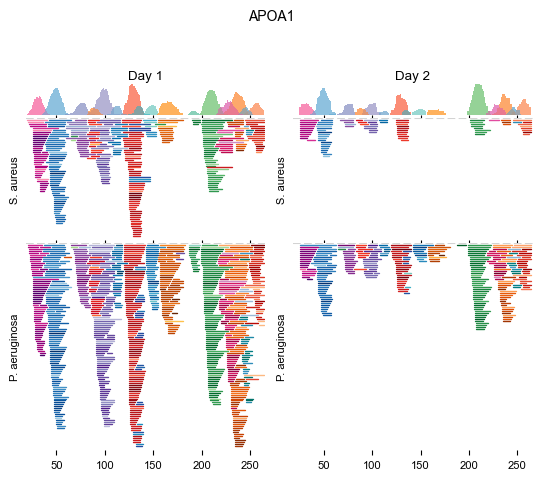

In [7]:
from pepnets.PeptiGrams import PeptiGram

design = pd.read_csv("../data/design.csv")
peptigram = PeptiGram(fm.datamatrix, design)
peptigram.plot_peptigram(
    "APOA1", groups=["S. aureus", "P. aeruginosa"], days=["Day 1", "Day 2"], size_factor=0.5,
    save_str="../plots/APOA1_pg.png"
)


In [8]:
topn = fm.get_topn()
topn.head(3)

,Sample 17 Day 1,Sample 18 Day 1,Sample 19 Day 1,Sample 20 Day 1,Sample 21 Day 1,Sample 22 Day 1,Sample 23 Day 1,Sample 24 Day 1,Sample 25 Day 1,Sample 26 Day 1,...,Sample 56 Day 3,Sample 57 Day 3,Sample 6 Day 1,Sample 7 Day 1,Sample 8 Day 1,Sample 9 Day 1,Sample 6 Day 2,Sample 7 Day 2,Sample 8 Day 2,Sample 9 Day 2
F1RX36_14,56.674605,56.385190,57.790651,60.037055,60.628009,60.390650,58.567739,60.580368,60.523998,59.960927,...,61.628429,61.541113,60.193319,57.933486,58.896834,55.940041,59.055682,59.879967,56.774901,53.716728
F1RX36_12,41.156538,36.808606,40.615099,37.461259,38.702363,41.088525,40.718204,35.638778,41.107344,36.707923,...,45.994196,46.233593,38.806222,40.492710,43.687794,36.538940,42.259950,39.406260,36.996664,3.974760
F1RX36_4,44.589290,48.515610,47.193364,46.128803,48.106766,46.631531,46.789575,40.252548,48.753892,40.889646,...,41.100286,41.238735,44.843393,48.460596,49.415482,42.134835,39.399840,38.351522,38.090766,38.519241


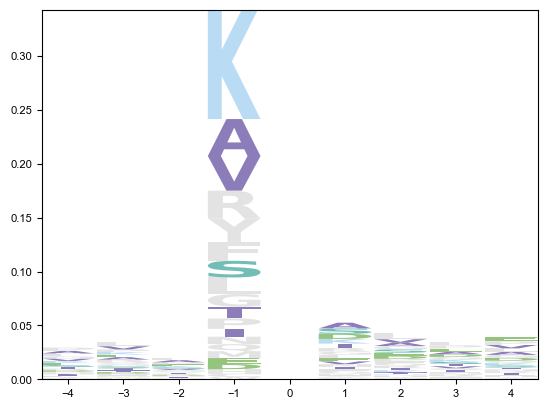

In [10]:
from pepnets.LogoPlot import LogoPlot

datamatrix = pd.read_csv("../data/data.csv")
sus_scrofa = pd.read_csv("../data/sus_scrofa.gz", sep="\t")
proteins = [p + "_PIG" for p in datamatrix["Protein"].unique()]
sus_scrofa = sus_scrofa[sus_scrofa["Entry Name"].isin(proteins)]


test_samples = design[design["group"] == "P. aeruginosa"]["sample"].tolist()
background_samples = design[design["group"] == "Ctrl"]["sample"].tolist()


lp = LogoPlot(fm.datamatrix, design, sus_scrofa, topn)
import matplotlib.pyplot as plt
height = lp.get_letter_heights(test_samples, background_samples)
fig, ax = plt.subplots(1,1)
lp.plot(height, ax=ax)
plt.savefig("../plots/logo.png", bbox_inches="tight")